In [ ]:
#hide
from mantisshrimp.all import *
import pandas as pd

# MantisShrimp

> Built on top of [pytorch-lightining](https://github.com/PyTorchLightning/pytorch-lightning), `MantisShrimp` is an object detection framework focused on application.

MantisShrimp is in very early development, all contributions are welcome!

Be sure to check the `issues` board =)

## Install

```python
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
pip install git+git://github.com/lgvaz/mantisshrimp.git
```

## Quick start

Instead of going over abstract features, let's see how to use the library with a practical example. We're going to be using the [wheat](https://www.kaggle.com/c/global-wheat-detection/overview/eccv-2020) dataset, where we are tasked to find the bounding boxes locations of wheat heads in the image

### Step 1: Data parsers

Often the step of getting our data into a standard format is the most difficult one. Almost all datasets comes in their unique own format, and writing custom code to handle each one of them can be very time consuming

Mantisshrimp provides an easy `Parser` interface for handling that, the main idea is that you only have to define how to parse a single sample and the library takes care of the rest

But before all, let's get the path to our dataset and read the CSV file using `pandas`.

In [ ]:
source = Path('/home/lgvaz/.data/wheat')
df = pd.read_csv(source/'train.csv')

There are two types of parsers we have to define:
* `InfoParser`: Parses metadata information about our images, like the image `id`, `file_path`, `height` and `width`
* `AnnotationParser`: Parses our annotations, like bounding boxes, masks and keypoints

In [ ]:
# TODO: Rename ImageParser to InfoParser
class WheatInfoParser(ImageParser):
    def iid(self, o): return o.image_id
    def height(self, o): return o.height
    def width(self, o): return o.width
    def file_path(self, o): return self.source/f'train/{o.image_id}.jpg'
    def __iter__(self): yield from self.data.itertuples()

In [ ]:
class WheatAnnotationParser(AnnotationParser):
    def iid(self, o): return o.image_id
    def oid(self, o): return 0
    def bbox(self, o): return BBox.from_xywh(*np.fromstring(o.bbox[1:-1], sep=','))
    def __iter__(self): yield from df.itertuples()

Define a `CategoryMap`, each `Category` receives an object id and it's name

In [ ]:
catmap = CategoryMap([Category(0, 'wheat')])

In [ ]:
parser = DataParser(df, source, catmap=catmap,
                    img_parser=WheatInfoParser,
                    annot_parser=WheatAnnotationParser)

The `.parse` method will run the parser over all data points, grouping all images that share the same `id`  
By default it returns two lists of `Records` with a 0.8/0.2 `train/validation` split

In [ ]:
train_rs,valid_rs = parser.parse()

### Step 2: Transforms, Datasets, and DataLoaders

Mantisshrimp does not implement transforms on it's own, but it instead relies on an easy interface for integrating any transforms library. It currently supports [albumentations](https://github.com/albumentations-team/albumentations) out of the box

In [ ]:
tfm = AlbuTfm([A.Flip(p=.8)])

Since we only defined augmentation transforms, we only want to apply them to the training dataset

In [ ]:
train_ds = Dataset(train_rs, tfm)
valid_ds = Dataset(valid_rs)

We use `RCNNDataLoader` for creating our data loaders, it receives the same arguments as a standard pytorch `DataLoader`

In [ ]:
train_dl = RCNNDataLoader(train_ds, batch_size=4, num_workers=8)
valid_dl = RCNNDataLoader(valid_ds, batch_size=4, num_workers=8)

**Bonus:** Let's take a look at how our transforms are affecting the same training sample:

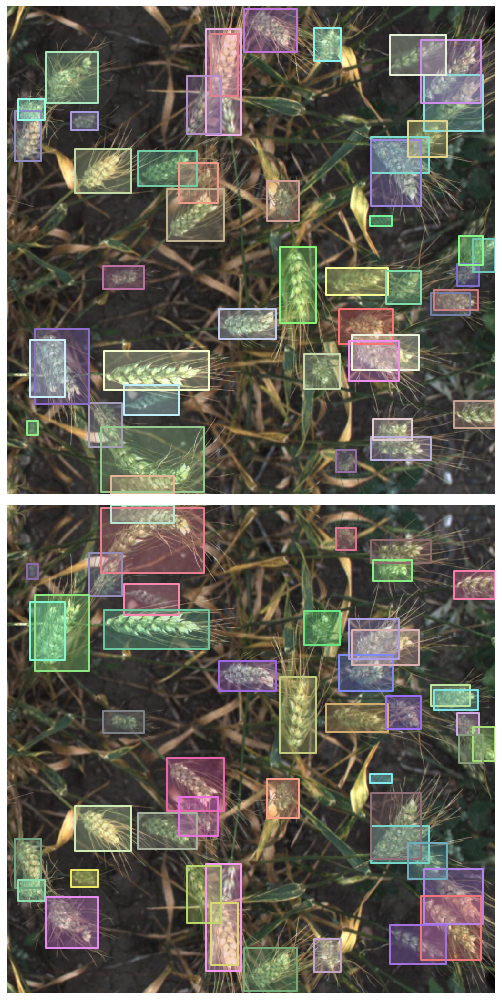

In [ ]:
items = [train_ds[0] for _ in range(2)]
grid2([partial(show_item, o, label=False) for o in items])

### Step 3 (optional): Metrics

Let's use the same evaluation metric that COCO uses

In [ ]:
metrics = [COCOMetric(valid_rs, catmap)]

Since our problem only contain bounding boxes, we're going to use the `FasterRCNN` model

### Step 3: Model and Training

Mantisshrimp provides a high and a mid level interface for training. One is not better than the other, they instead serve different purposes:
* High level interface: For quick prototyping in a jupyter notebook like environment
* Mid level interface: For more reproducible experiments. Great for writing experiments that can be launched in terminal with different hyperparameters.

#### High level interface (Learner)

The `Learner` interface is inspired (and very similar) to the [fastai](https://github.com/fastai/fastai2) `Learner`. It aims to provide a very productive experience for prototyping in a jupyter notebook like environment.  
It comes bundled with additional functionallity, like inbuilt learning rate schedulers and differential learning rates for training unfreezed models.

First of all, let's create our model

In [ ]:
model = MantisFasterRCNN(len(catmap), metrics=metrics)

The `Learner` receives an argument called `opt_fn`, it will call this function passing the model parameters and it expects to receive back a torch `Optimizer`. We are going to use `partial` to pass any additional paramters to our `SGD` optimizer.

In [ ]:
opt_fn = partial(SGD, momentum=.9, weight_decay=5e-4)

In [ ]:
learn = Learner(model, train_dl, valid_dl, opt_fn)

`fit_one_cycle` will train adjusting the learning rate acording with the [1cycle learning rate policy](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.OneCycleLR).

In [ ]:
learn.fit_one_cycle(5, 1e-3)

#### Mid level interface (Lightning Trainer)

This is almost pure Lightning, go crazy!  
For simplicity, let's just define a model that uses `SGD` and the 1cycle policy like before.

In [ ]:
class WheatModel(MantisFasterRCNN):
    def configure_optimizers(self):
        opt = SGD(params(self), lr=1e-3, momentum=.9, weight_decay=5e-4)
        sched = OneCycleLR(opt, max_lr=1e-3, total_steps=len(train_dl), pct_start=.3)
        return [opt], [{'scheduler':sched, 'interval':'step'}]

In [ ]:
model = WheatModel(len(catmap), metrics=metrics)

In [ ]:
trainer = Trainer(max_epochs=1, gpus=1)
trainer.fit(model, train_dl, valid_dl)

### Extra: Visualize results

Because we are using Lightning logs are automatically saved for us in a tensorboard format. Other cool loggers like [wandb](https://www.wandb.com/) are also provided by lightning!

Let's take a look at some model predictions (`learn.show_results` if using `Learner`)

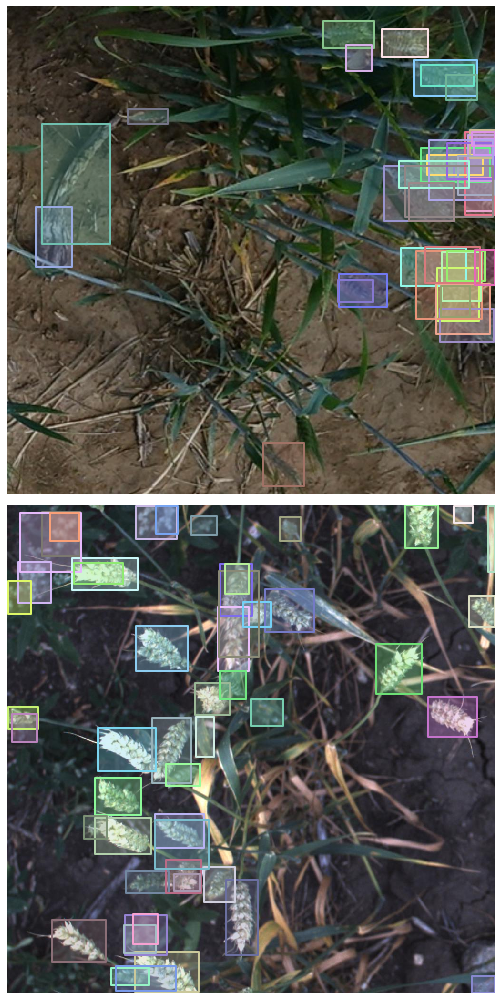

In [ ]:
rs = random.choices(valid_rs, k=2)
ims,preds = model.predict(rs=rs)
show_preds(ims, preds)